In [1]:

import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv(r"C:\Users\nandana\Desktop\walmart\train.csv (1)\train.csv")
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df=data.copy()

In [7]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
# Clean column names
df.columns = df.columns.str.strip()

# Rename common mistakes
rename_map = {
    "store": "Store",
    "dept": "Dept",
    "weekly_sales": "Weekly_Sales",
    "Weekly Sales": "Weekly_Sales",
    "date": "Date",
    "isholiday": "IsHoliday"
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

print("Columns:", df.columns.tolist())

Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']


In [11]:
# Convert Date column
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Convert types
df["Store"] = df["Store"].astype(int)
df["Dept"] = df["Dept"].astype(int)
df["Weekly_Sales"] = df["Weekly_Sales"].astype(float)
df["IsHoliday"] = df["IsHoliday"].astype(bool)

# Sort properly
df = df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)

print(df.dtypes)


Store                    int32
Dept                     int32
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object


In [13]:
#outlier 
numeric_cols = df.select_dtypes(include=[np.number]).columns

z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
outliers = df[(z_scores > 3).any(axis=1)]

print("Outliers found:", len(outliers))

# Remove outliers
df = df[(z_scores < 3).all(axis=1)]


Outliers found: 8848


In [15]:
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns

z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())

outliers = df[(z_scores > 3).any(axis=1)]
print("Number of outlier rows:", len(outliers))

outliers.head()  # view outliers


Number of outlier rows: 9787


,Store,Dept,Date,Weekly_Sales,IsHoliday
241,1,2,2011-12-23,65615.36,False
614,1,5,2010-11-26,70158.86,True
666,1,5,2011-11-25,79340.15,True
900,1,7,2010-11-26,72635.06,True
952,1,7,2011-11-25,71151.34,True


In [17]:
df_out = df[(z_scores < 3).all(axis=1)].copy()

print("Original rows:", len(df))
print("After outlier removal:", len(df_out))
print("Removed:", len(df) - len(df_out))


Original rows: 412722
After outlier removal: 402935
Removed: 9787


In [19]:
df = df_out.copy()


In [21]:
df_out.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [23]:
df_out.size

2014675

In [25]:
df_out.shape

(402935, 5)

In [29]:
df_out.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [31]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402935 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         402935 non-null  int32         
 1   Dept          402935 non-null  int32         
 2   Date          402935 non-null  datetime64[ns]
 3   Weekly_Sales  402935 non-null  float64       
 4   IsHoliday     402935 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2)
memory usage: 12.7 MB


In [37]:
df_out.describe()

,Store,Dept,Date,Weekly_Sales
count,402935.000000,402935.000000,402935,402935.000000
mean,22.392128,43.284418,2011-06-18 05:45:47.922121472,12409.026466
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000
25%,11.000000,18.000000,2010-10-08 00:00:00,1906.960000
50%,22.000000,36.000000,2011-06-17 00:00:00,6952.420000
75%,33.000000,71.000000,2012-02-24 00:00:00,17724.235000
max,45.000000,99.000000,2012-10-26 00:00:00,64505.440000
std,12.779489,29.970295,NaN,14262.312750


In [39]:
df_out.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
421565    False
421566    False
421567    False
421568    False
421569    False
Length: 402935, dtype: bool

In [53]:
df_out.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

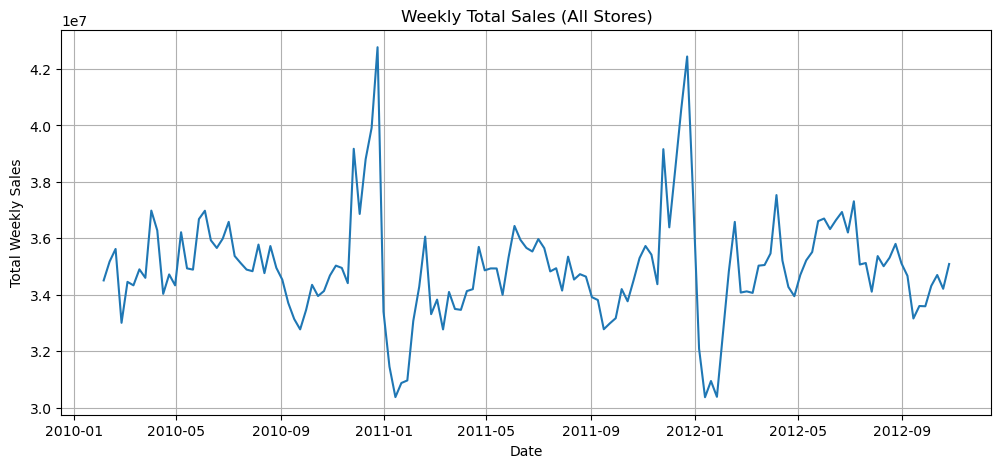

In [43]:
# Weekly Total Sales (Line Chart)
import matplotlib.pyplot as plt

weekly_total = df.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(12,5))
plt.plot(weekly_total.index, weekly_total.values)
plt.title("Weekly Total Sales (All Stores)")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.grid(True)
plt.show()


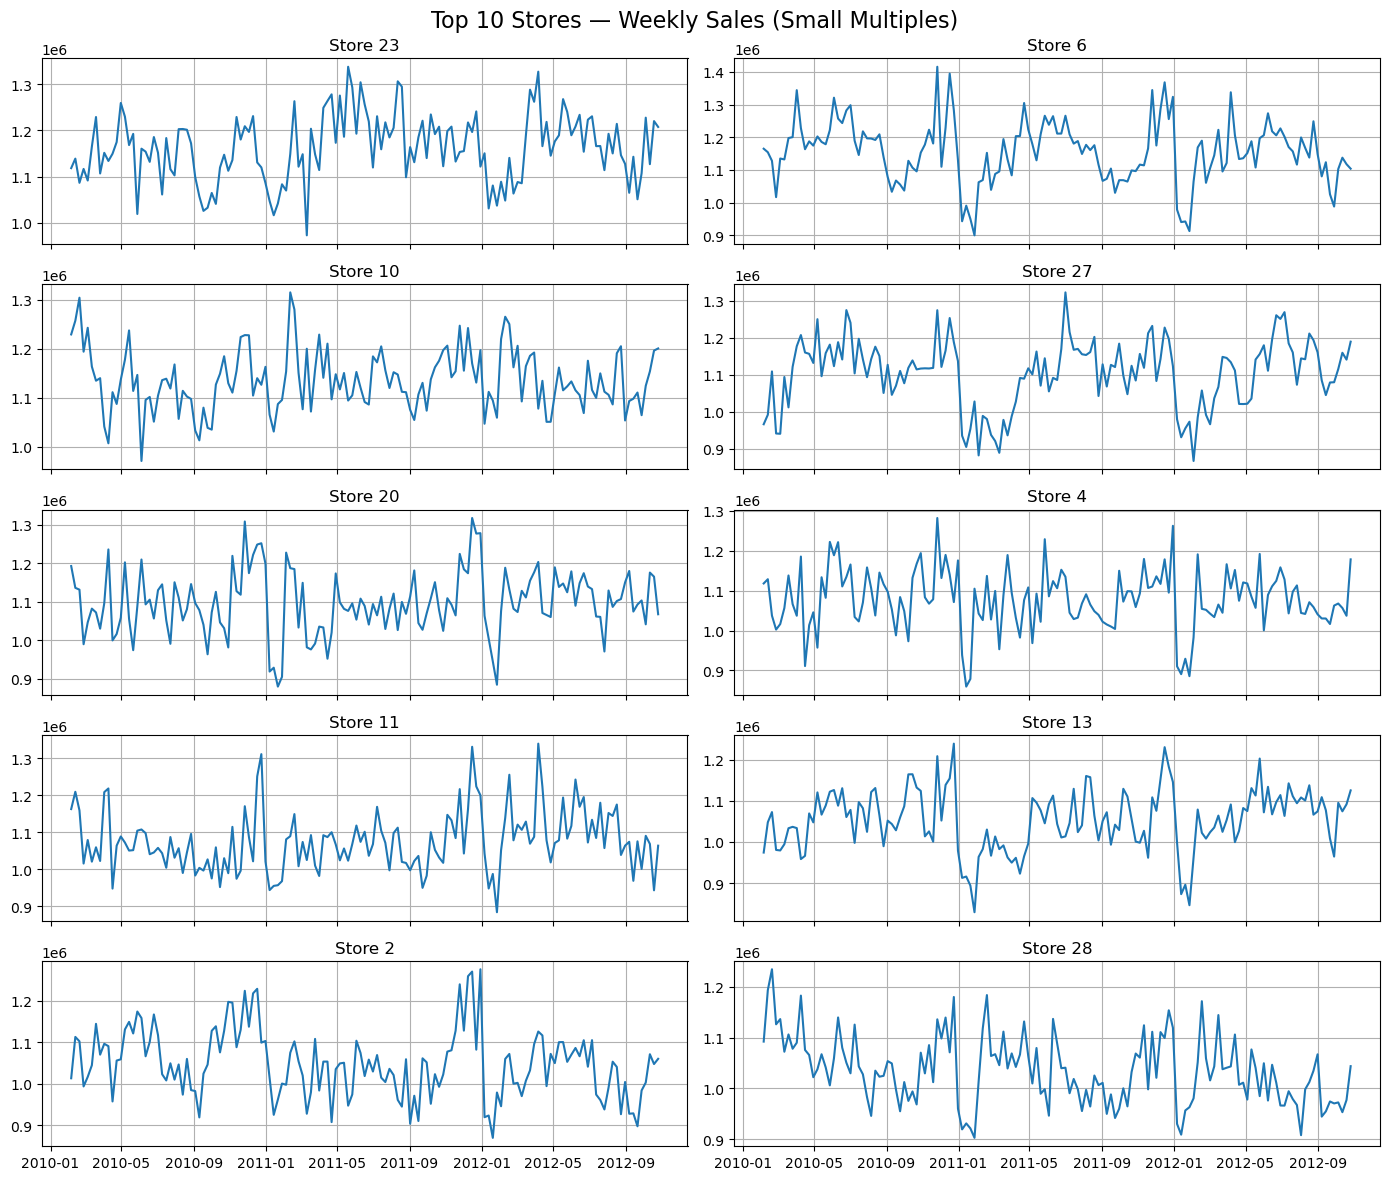

In [45]:
#Store-level Sales Trend
import matplotlib.pyplot as plt

top_stores = (
    df.groupby("Store")["Weekly_Sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True)

axes = axes.flatten()

for i, store_id in enumerate(top_stores):
    g = df[df["Store"] == store_id]
    g_weekly = g.groupby("Date")["Weekly_Sales"].sum()

    axes[i].plot(g_weekly.index, g_weekly.values)
    axes[i].set_title(f"Store {store_id}")
    axes[i].grid(True)

plt.suptitle("Top 10 Stores — Weekly Sales (Small Multiples)", fontsize=16)
plt.tight_layout()
plt.show()


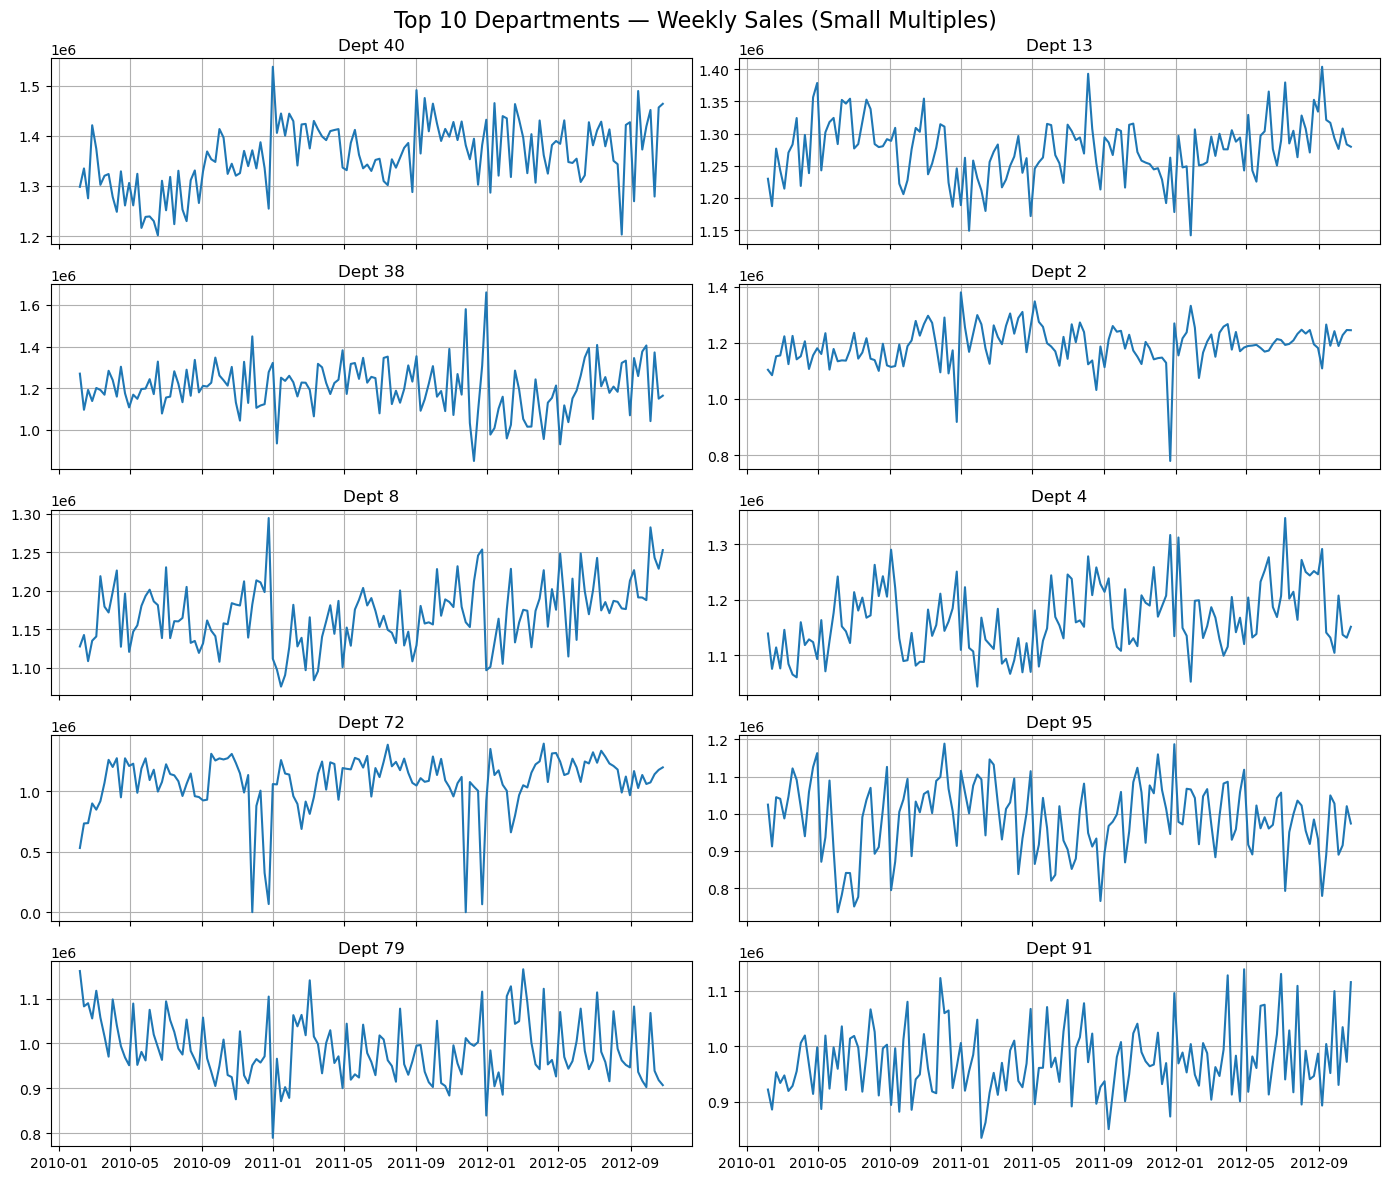

In [47]:
#Department-level Sales Trend
top_depts = (
    df.groupby("Dept")["Weekly_Sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True)

axes = axes.flatten()

for i, dept_id in enumerate(top_depts):
    g = df[df["Dept"] == dept_id]
    g_weekly = g.groupby("Date")["Weekly_Sales"].sum()

    axes[i].plot(g_weekly.index, g_weekly.values)
    axes[i].set_title(f"Dept {dept_id}")
    axes[i].grid(True)

plt.suptitle("Top 10 Departments — Weekly Sales (Small Multiples)", fontsize=16)
plt.tight_layout()
plt.show()


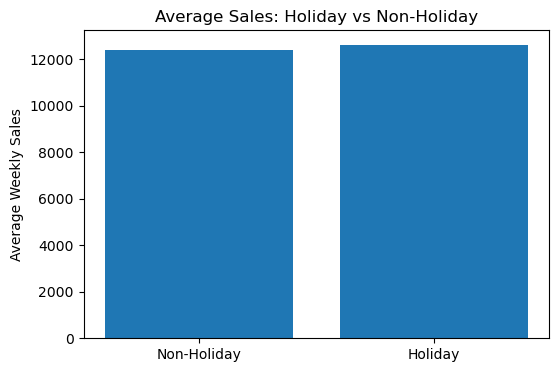

In [49]:
# Holiday vs Non-Holiday Comparison
holiday_group = df.groupby("IsHoliday")["Weekly_Sales"].mean()

plt.figure(figsize=(6,4))
plt.bar(["Non-Holiday", "Holiday"], holiday_group.values)
plt.title("Average Sales: Holiday vs Non-Holiday")
plt.ylabel("Average Weekly Sales")
plt.show()

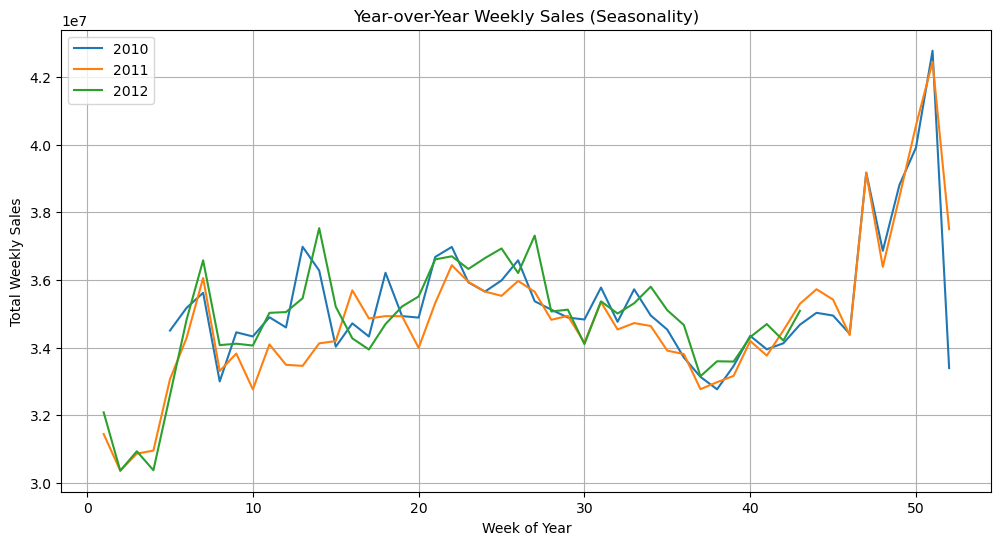

In [51]:
# Year-over-Year Weekly Sales (Seasonality Chart)
df["year"] = df["Date"].dt.year
df["week"] = df["Date"].dt.isocalendar().week.astype(int)

yoy = df.groupby(["year", "week"])["Weekly_Sales"].sum().reset_index()

plt.figure(figsize=(12,6))

for year, g in yoy.groupby("year"):
    plt.plot(g["week"], g["Weekly_Sales"], label=str(year))

plt.title("Year-over-Year Weekly Sales (Seasonality)")
plt.xlabel("Week of Year")
plt.ylabel("Total Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
df_fe = df_out.copy()

# Time Features
df_fe["year"] = df_fe["Date"].dt.year
df_fe["month"] = df_fe["Date"].dt.month
df_fe["weekofyear"] = df_fe["Date"].dt.isocalendar().week.astype(int)
df_fe["dayofweek"] = df_fe["Date"].dt.dayofweek


In [57]:
def create_lag_features(g):
    g = g.sort_values("Date").copy()

    g["lag_1"] = g["Weekly_Sales"].shift(1)
    g["lag_52"] = g["Weekly_Sales"].shift(52)

    g["rolling_mean_4"] = g["Weekly_Sales"].shift(1).rolling(4).mean()
    g["rolling_std_4"] = g["Weekly_Sales"].shift(1).rolling(4).std()

    return g

df_fe = df_fe.groupby(["Store", "Dept"], group_keys=False).apply(create_lag_features)


In [58]:
mean_sales = df_fe["Weekly_Sales"].mean()

df_fe["lag_1"].fillna(mean_sales, inplace=True)
df_fe["lag_52"].fillna(mean_sales, inplace=True)
df_fe["rolling_mean_4"].fillna(mean_sales, inplace=True)
df_fe["rolling_std_4"].fillna(0, inplace=True)

print(df_fe.head())


   Store  Dept       Date  Weekly_Sales  IsHoliday  year  month  weekofyear  \
0      1     1 2010-02-05      24924.50      False  2010      2           5   
1      1     1 2010-02-12      46039.49       True  2010      2           6   
2      1     1 2010-02-19      41595.55      False  2010      2           7   
3      1     1 2010-02-26      19403.54      False  2010      2           8   
4      1     1 2010-03-05      21827.90      False  2010      3           9   

   dayofweek         lag_1        lag_52  rolling_mean_4  rolling_std_4  
0          4  12409.026466  12409.026466    12409.026466       0.000000  
1          4  24924.500000  12409.026466    12409.026466       0.000000  
2          4  46039.490000  12409.026466    12409.026466       0.000000  
3          4  41595.550000  12409.026466    12409.026466       0.000000  
4          4  19403.540000  12409.026466    32990.770000   12832.106391  


In [61]:
#Time-Based Train/Validation Split
VALID_WEEKS = 4  # use 4 for better accuracy

def mark_validation(g):
    g = g.sort_values("Date").copy()
    g["is_val"] = False
    if len(g) > VALID_WEEKS:
        g.loc[g.index[-VALID_WEEKS:], "is_val"] = True
    return g

df_split = df_fe.groupby(["Store", "Dept"], group_keys=False).apply(mark_validation)

train_df = df_split[df_split["is_val"] == False].reset_index(drop=True)
val_df   = df_split[df_split["is_val"] == True].reset_index(drop=True)

print("Train rows:", len(train_df))
print("Validation rows:", len(val_df))


Train rows: 390295
Validation rows: 12640


In [63]:
FEATURES = [
    "Store", "Dept",
    "year", "month", "weekofyear", "dayofweek",
    "IsHoliday",
    "lag_1", "lag_52",
    "rolling_mean_4", "rolling_std_4"
]

TARGET = "Weekly_Sales"

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_val = val_df[FEATURES]
y_val = val_df[TARGET]

print("X_train shape:", X_train.shape)


X_train shape: (390295, 11)


In [69]:
from xgboost import XGBRegressor
from math import sqrt

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

val_pred = model.predict(X_val)
print(" Cleaning complete!")

 Cleaning complete!


In [67]:
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)
    )

mae = np.mean(np.abs(y_val - val_pred))
rmse = np.sqrt(np.mean((y_val - val_pred)**2))
smape_score = smape(y_val.values, val_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("SMAPE:", smape_score)


MAE: 948.4819832836107
RMSE: 1765.3006184350572
SMAPE: 32.10079398912398


In [71]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, val_pred)
print("R² Score:", r2)



R² Score: 0.9865841745112668


In [75]:
def adjusted_r2(r2, n, k):
    return 1 - (1-r2)*(n-1)/(n-k-1)

adj_r2 = adjusted_r2(r2, len(y_val), X_val.shape[1])
print("Adjusted R²:", adj_r2)


from sklearn.metrics import explained_variance_score
evs = explained_variance_score(y_val, val_pred)
print("Explained Variance:", evs)




Adjusted R²: 0.9865724882521303
Explained Variance: 0.9866103883211648


In [77]:
# ---- CONFIG ----
H = 4  # forecast horizon in weeks
RETRAIN_ON_FULL = True   # set True to retrain on all history before forecasting
MODEL_PATH = Path("models/xgb_walmart_full.joblib")
FORECAST_OUT = Path("data/forecast_output/forecast_4wk.csv")
FORECAST_OUT.parent.mkdir(parents=True, exist_ok=True)

In [79]:
# Ensure FEATURES list (adjust if your pipeline used different names)
# -------------------------
FEATURES = [
    "Store", "Dept",
    "year", "month", "weekofyear", "dayofweek",
    "IsHoliday",
    "lag_1", "lag_52",
    "rolling_mean_4", "rolling_std_4"
]

TARGET = "Weekly_Sales"

In [81]:
# Sanity checks: df_fe must exist
# -------------------------
try:
    df_fe
except NameError:
    raise RuntimeError("df_fe not found. Run the feature engineering steps first so df_fe exists.")

# Ensure Date is datetime
df_fe["Date"] = pd.to_datetime(df_fe["Date"], errors="coerce")

In [83]:
# Keep only rows where features exist
missing = [f for f in FEATURES if f not in df_fe.columns]
if missing:
    raise RuntimeError(f"Missing features in df_fe: {missing}. Ensure feature engineering created those columns.")

In [85]:
# -------------------------
# Retrain model on full history (recommended)
# -------------------------
if RETRAIN_ON_FULL:
    print("Retraining XGBoost on full history...")
    X_full = df_fe[FEATURES].copy()
    y_full = df_fe[TARGET].copy()

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_full, y_full)
    joblib.dump(model, MODEL_PATH)
    print(f"Retrained and saved model to: {MODEL_PATH}")
else:
    # load model if exists
    if MODEL_PATH.exists():
        model = joblib.load(MODEL_PATH)
        print(f"Loaded model from {MODEL_PATH}")
    elif 'model' in globals():
        print("Using existing 'model' variable in memory.")
    else:
        raise RuntimeError("No trained model found. Set RETRAIN_ON_FULL=True or train model and save it to models/xgb_walmart_full.joblib")


Retraining XGBoost on full history...
Retrained and saved model to: models\xgb_walmart_full.joblib


In [87]:
# Iterative forecasting per Store-Dept
# -------------------------
forecast_rows = []

groups = list(df_fe.groupby(["Store", "Dept"]).groups.keys())
print(f"Forecasting for {len(groups)} series (Store,Dept pairs). Horizon: {H} weeks")

for idx, (store, dept) in enumerate(groups, 1):
    # progress
    if idx % 200 == 0 or idx == 1 or idx == len(groups):
        print(f"[{idx}/{len(groups)}] Store {store}, Dept {dept}")

    # history for this series
    hist = df_fe[(df_fe["Store"] == store) & (df_fe["Dept"] == dept)].sort_values("Date").copy()
    if hist.empty:
        continue

    # ensure we have at least 1 row to base lag_1 on
    last_date = hist["Date"].max()
    history = hist.copy()  # we'll append predicted rows here (with Weekly_Sales = predicted)

    for step in range(1, H + 1):
        next_date = last_date + pd.Timedelta(weeks=step)

        # Build feature row based on latest history
        # Use the last available summary from history
        last_row = history.iloc[-1]

        # compute lag_1 (last known weekly_sales)
        lag_1 = float(last_row["Weekly_Sales"])

        # attempt lag_52 (same week last year) using history
        lag_52_date = next_date - pd.Timedelta(weeks=52)
        lag52_match = history[history["Date"] == lag_52_date]
        if not lag52_match.empty:
            lag_52 = float(lag52_match["Weekly_Sales"].iloc[0])
        else:
            # fallback: mean of last year in this history if available else overall mean
            last_year_mean = history[history["Date"] >= (last_date - pd.Timedelta(weeks=52))]["Weekly_Sales"].mean()
            if np.isnan(last_year_mean):
                lag_52 = float(df_fe["Weekly_Sales"].mean())
            else:
                lag_52 = float(last_year_mean)

        # rolling features from last up-to-4 observations
        recent_sales = history["Weekly_Sales"].iloc[-4:].values
        if len(recent_sales) == 0:
            rmean_4 = float(df_fe["Weekly_Sales"].mean())
            rstd_4 = 0.0
        else:
            rmean_4 = float(np.mean(recent_sales))
            rstd_4 = float(np.std(recent_sales, ddof=0))

        # compose feature dict
        f = {
            "Store": int(store),
            "Dept": int(dept),
            "year": int(next_date.year),
            "month": int(next_date.month),
            "weekofyear": int(next_date.isocalendar()[1]),
            "dayofweek": int(next_date.dayofweek),
            "IsHoliday": 0,   # you can replace this using your holiday calendar if available
            "lag_1": lag_1,
            "lag_52": lag_52,
            "rolling_mean_4": rmean_4,
            "rolling_std_4": rstd_4
        }

        # Ensure column order and dtype
        X_row = pd.DataFrame([f])[FEATURES]

        # Predict
        try:
            pred = float(model.predict(X_row)[0])
        except Exception as e:
            print(f"Prediction error for Store {store} Dept {dept} at step {step}: {e}")
            pred = float(rmean_4)  # fallback to recent mean

        # Append forecast row to results
        forecast_rows.append({
            "Store": store,
            "Dept": dept,
            "Date": next_date,
            "Predicted_Sales": pred
        })

        # Append new predicted row into history so next iteration uses it as lag
        new_hist_row = {
            "Store": store,
            "Dept": dept,
            "Date": next_date,
            "Weekly_Sales": pred,
            "IsHoliday": 0,
            "year": next_date.year,
            "month": next_date.month,
            "weekofyear": int(next_date.isocalendar()[1]),
            "dayofweek": next_date.dayofweek,
            "lag_1": lag_1,
            "lag_52": lag_52,
            "rolling_mean_4": rmean_4,
            "rolling_std_4": rstd_4
        }
        history = pd.concat([history, pd.DataFrame([new_hist_row])], ignore_index=True)

    # end of horizon loop for a series

# -------------------------
# Save forecasts
# -------------------------
forecast_df = pd.DataFrame(forecast_rows)
forecast_df = forecast_df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)

forecast_df.to_csv(FORECAST_OUT, index=False)

Forecasting for 3278 series (Store,Dept pairs). Horizon: 4 weeks
[1/3278] Store 1, Dept 1
[200/3278] Store 3, Dept 71
[400/3278] Store 6, Dept 37
[600/3278] Store 9, Dept 9
[800/3278] Store 11, Dept 81
[1000/3278] Store 14, Dept 40
[1200/3278] Store 17, Dept 8
[1400/3278] Store 19, Dept 58
[1600/3278] Store 22, Dept 28
[1800/3278] Store 24, Dept 98
[2000/3278] Store 27, Dept 50
[2200/3278] Store 30, Dept 21
[2400/3278] Store 33, Dept 7
[2600/3278] Store 35, Dept 90
[2800/3278] Store 39, Dept 4
[3000/3278] Store 41, Dept 67
[3200/3278] Store 44, Dept 95
[3278/3278] Store 45, Dept 98


In [88]:
print(f"Saved forecast to: {FORECAST_OUT}")
print("Sample of forecasts:")
print(forecast_df.head(10))

Saved forecast to: data\forecast_output\forecast_4wk.csv
Sample of forecasts:
   Store  Dept       Date  Predicted_Sales
0      1     1 2012-11-02     36067.382812
1      1     1 2012-11-09     27361.074219
2      1     1 2012-11-16     27910.794922
3      1     1 2012-11-23     31398.513672
4      1     2 2012-11-02     46439.925781
5      1     2 2012-11-09     45121.433594
6      1     2 2012-11-16     45299.492188
7      1     2 2012-11-23     46399.710938
8      1     3 2012-11-02      9548.946289
9      1     3 2012-11-09      9929.829102


In [91]:
import joblib
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODEL_DIR / "xgb_walmart_full.joblib"

# Save trained model
joblib.dump(model, MODEL_PATH)

print(f"Model saved successfully at: {MODEL_PATH}")


Model saved successfully at: models\xgb_walmart_full.joblib


In [97]:
#To Load the Model Later 

model = joblib.load("models/xgb_walmart_full.joblib")
print("Model loaded successfully!")

Model loaded successfully!
